## Prerequisites

In [1]:
!mkdir -p dataset/scamps_videos_example/matrix
!mkdir -p dataset/scamps_videos_example/labels
!mkdir modules

In [2]:
! wget https://facesyntheticspubwedata.blob.core.windows.net/neurips-2022/scamps_videos_example.tar.gz
! tar -xzvf scamps_videos_example.tar.gz -C dataset/scamps_videos_example/matrix
! mv dataset/scamps_videos_example/matrix/scamps_videos_example/* dataset/scamps_videos_example/matrix
! rm -rf dataset/scamps_videos_example/matrix/scamps_videos_example

--2024-06-05 08:36:30--  https://facesyntheticspubwedata.blob.core.windows.net/neurips-2022/scamps_videos_example.tar.gz
Resolving facesyntheticspubwedata.blob.core.windows.net (facesyntheticspubwedata.blob.core.windows.net)... 20.38.109.4
Connecting to facesyntheticspubwedata.blob.core.windows.net (facesyntheticspubwedata.blob.core.windows.net)|20.38.109.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1228897063 (1.1G) [application/octet-stream]
Saving to: ‘scamps_videos_example.tar.gz’

scamps_videos_examp 100%[===================>]   1.14G  9.24MB/s    in 2m 0s   

2024-06-05 08:38:31 (9.77 MB/s) - ‘scamps_videos_example.tar.gz’ saved [1228897063/1228897063]

scamps_videos_example/
scamps_videos_example/P000009.mat
scamps_videos_example/P000010.mat
scamps_videos_example/P000008.mat
scamps_videos_example/P000001.mat
scamps_videos_example/P000002.mat
scamps_videos_example/P000003.mat
scamps_videos_example/P000004.mat
scamps_videos_example/P000005.mat
scamps

In [9]:
!pip install cupy-cuda11x

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.4/95.4 MB 9.7 MB/s eta 0:00:00


In [4]:
import cupy as cp
import gc

In [ ]:
# import yaml
# with open("config.yaml", 'r') as file:
#     CONFIG = yaml.safe_load(file)

In [ ]:
import os
import h5py
import numpy as np
import pandas as pd

# Dataset

## Make and Prepare Dataset

### Make Input

In [28]:
import cv2
import importlib
from modules import processing
importlib.reload(processing)

frame_standardization = processing.StandardizeFrame(
    target_resolution=(240,240),
    target_frame_rate=1,
    target_color_space=cv2.COLOR_BGR2RGB)

HR_dataset_formaxion = processing.HRcompute(
    0.4,
    4,
    4,
    30)

In [ ]:
scamps_dir = "dataset/scamps_videos_example/matrix/"

matrix_files = os.listdir(scamps_dir)

scamps = []
for f,file in enumerate(matrix_files):
  if file != ".ipynb_checkpoints":
    scamps.append(h5py.File(scamps_dir+file,"r")["Xsub"])

for s in range(len(scamps)):
  scamps[s] = np.asarray(scamps[s]).astype(np.short)
  print(f"File: {s} Loaded")

scamps = cp.array(scamps)

print(scamps.shape)
print(type(scamps))

In [19]:
scamps = cp.split(scamps,int(600/8),axis=-1)

In [20]:
print(scamps[0].shape)
print(type(scamps),len(scamps),type(scamps[0]))

(10, 3, 240, 240, 8)
<class 'list'> 75 <class 'cupy.ndarray'>


In [22]:
scamps = cp.array(scamps)

print(scamps.shape)
print(type(scamps))

(75, 10, 3, 240, 240, 8)
<class 'cupy.ndarray'>


In [23]:
scamps = scamps.reshape(750,3,240,240,8)
scamps = cp.moveaxis(scamps,[0,1,2,3,4],[0,4,2,3,1])

print(type(scamps), scamps.shape)

<class 'cupy.ndarray'> (750, 8, 240, 240, 3)


In [35]:
for s in range(len(scamps)):
  scamps[s] = cp.array(frame_standardization.standardize(scamps[s].get(),current_frame_rate=1))

print(type(scamps),scamps.shape)

<class 'cupy.ndarray'> (750, 8, 240, 240, 3)


### Make Targets

In [49]:
scamps_labels_dir = "dataset/scamps_videos_example/labels/"

label_files = os.listdir(scamps_labels_dir)
scamps_labels = []
for f,file in enumerate(label_files):
  if file != ".ipynb_checkpoints":
    scamps_labels.append(pd.read_csv(scamps_labels_dir+file)["d_ppg"])

scamps_labels = cp.array(scamps_labels)

print(type(scamps_labels),scamps_labels.shape)

<class 'cupy.ndarray'> (10, 600)


In [50]:
scamps_labels = cp.array(cp.split(scamps_labels,int(600/8),axis=-1))
print(type(scamps_labels),scamps_labels.shape)

<class 'cupy.ndarray'> (75, 10, 8)


In [52]:
scamps_labels = scamps_labels.reshape(750,8)
print(type(scamps_labels),scamps_labels.shape)

<class 'cupy.ndarray'> (750, 8)


# Training Network

In [54]:
# @title NeuralNet


import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN3D(nn.Module):
    def __init__(self):
        super(CNN3D, self).__init__()
        # 3D Convolutional layers
        self.conv1 = nn.Conv3d(in_channels=3, out_channels=16, kernel_size=(3, 3, 3), stride=1, padding=1)
        self.conv2 = nn.Conv3d(in_channels=16, out_channels=32, kernel_size=(3, 3, 3), stride=1, padding=1)
        self.conv3 = nn.Conv3d(in_channels=32, out_channels=64, kernel_size=(3, 3, 3), stride=1, padding=1)

        # Fully connected layers
        self.fc1 = nn.Linear(64 * 8 * 30 * 30, 128)
        self.fc2 = nn.Linear(128, 8)

    def forward(self, x):
        # Apply 3D convolutions
        x = F.relu(self.conv1(x))
        x = F.max_pool3d(x, kernel_size=(1, 2, 2))  # Only pool spatial dimensions
        x = F.relu(self.conv2(x))
        x = F.max_pool3d(x, kernel_size=(1, 2, 2))
        x = F.relu(self.conv3(x))
        x = F.max_pool3d(x, kernel_size=(1, 2, 2))

        # Flatten the output of the last conv layer
        x = x.view(x.size(0), -1)

        # Apply fully connected layers
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Instantiate the model
model = CNN3D()

# Print the model architecture
print(model)


CNN3D(
  (conv1): Conv3d(3, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (conv2): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (conv3): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (fc1): Linear(in_features=460800, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=8, bias=True)
)


In [57]:
scamps = cp.asnumpy(scamps)
scamps_labels = cp.asnumpy(scamps_labels)

scamps = torch.tensor(scamps).cuda()
scamps_labels = torch.tensor(scamps).cuda()

<ipython-input-57-29f26942048c>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  scamps_labels = torch.tensor(scamps).cuda()


In [64]:
# @title Dataset/Dataloader Creation

import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split

class CustomDataset(Dataset):
    def __init__(self, input_data, target_data):
        self.input_data = input_data
        self.target_data = target_data

    def __len__(self):
        return len(self.input_data)

    def __getitem__(self, idx):
        input_sample = self.input_data[idx]
        target_sample = self.target_data[idx]
        return input_sample, target_sample

dataset = CustomDataset(scamps, scamps_labels)

train_size = int(0.7 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

batch_size = int(0.2*train_size)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

print("Training dataset size:", len(train_dataset))
print("Testing dataset size:", len(test_dataset))

Training dataset size: 525
Testing dataset size: 225


In [66]:
# @title Training

import torch.optim as optim

# Define the loss function and optimizer
criterion = nn.MSELoss()  # Mean Squared Error loss
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer

model = CNN3D().cuda()

num_epochs = 1000
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for inputs, targets in train_dataloader:

      inputs = inputs.to(torch.float32)
      targets = targets.to(torch.float32)

      optimizer.zero_grad()  # Zero the parameter gradients

      # Forward pass
      outputs = model(inputs)

      # Compute the loss
      loss = criterion(outputs, targets)

      # Backward pass and optimization
      loss.backward()
      optimizer.step()

      # Accumulate the loss
      running_loss += loss.item() * inputs.size(0)

    # Calculate average loss for the epoch
    epoch_loss = running_loss / len(train_dataset)

    # Print the average loss for the epoch
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')

# Optionally, evaluate the model on the test dataset
model.eval()  # Set model to evaluation mode
test_loss = 0.0

# Iterate over the test dataset
for inputs, targets in test_dataloader:

    inputs = inputs.to(torch.float32)
    targets = targets.to(torch.float32)

    # Forward pass
    outputs = model(inputs)

    # Compute the loss
    test_loss += criterion(outputs, targets).item() * inputs.size(0)

# Calculate average test loss
test_loss /= len(test_dataset)

# Print the average test loss
print(f'Test Loss: {test_loss:.4f}')

RuntimeError: Given groups=1, weight of size [16, 3, 3, 3, 3], expected input[105, 8, 240, 240, 3] to have 3 channels, but got 8 channels instead

# Pipeline

In [ ]:
import time

import cv2
import numpy as np
from modules import processing
import matplotlib.pyplot as plt

In [ ]:
frame_standardization = processing.StandardizeFrame(target_resolution=(640,480),target_frame_rate=30,target_color_space=cv2.COLOR_BGR2RGB)
face_detect = processing.FaceDetection()
ppgi = processing.PPGIcomputation(alpha=0.5,filter_size=5,target_frame_size=(640,480))
HR = processing.HRcompute(0.4,4,4,30)

In [ ]:
def record():

    # Initialize Video Capture
    cap = cv2.VideoCapture(0)
    CAMERA_WIDTH = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    CAMERA_HEIGHT = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    CAMERA_FPS = cap.get(cv2.CAP_PROP_FPS)
    print((CAMERA_WIDTH,CAMERA_HEIGHT), CAMERA_FPS)

    # Check if camers opened succesfully
    if not cap.isOpened():
        print("Error: Could not open video capture")
        return

    while True:
        ''' TEST FACE IS DETECTED '''

        # Capture frame-by-frame
        ret, frame = cap.read()
        if not ret:
            break

        # Detect Face
        faces, frame = face_detect.extract([frame])
        frame = frame[0]
        face = faces[0]

        for (x, y, w, h) in face:
            cv2.rectangle(frame, (x, y), (x + w, y + h), (255, 0, 0), 2)

        cv2.imshow("Video Stream", frame)

        # Break the loop on "q" key press
        if cv2.waitKey(1) & 0xFF == ord("n"):
            break
    cap.release()
    cv2.destroyAllWindows()

    # Initialize Video Capture
    cap = cv2.VideoCapture(0)
    CAMERA_WIDTH = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    CAMERA_HEIGHT = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    CAMERA_FPS = cap.get(cv2.CAP_PROP_FPS)
    print((CAMERA_WIDTH,CAMERA_HEIGHT), CAMERA_FPS)

    frames = []
    heart_rate = 0
    while True:

        # Capture frame-by-frame
        ret, frame = cap.read()
        if not ret:
            break

        ''' DETECT FACES '''
        faces, frame = face_detect.extract([frame])
        frame = frame[0]
        face = faces[0]

        for (x, y, w, h) in face:
            cv2.rectangle(frame, (x, y), (x + w, y + h), (255, 255, 255), 2)
            text_x = x
            text_y = y + h + 25
            cv2.putText(frame, f"{heart_rate} BPM", (text_x, text_y), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)

        cv2.imshow("Video Stream", frame)

        ''' COMPUTE HSV & PPG '''
        if len(faces)==1:
            for (x, y, w, h) in face:
                frame = frame[y+5:(y+h)-5,x+5:(x+w)-5,:]
                if frame.size!=0 and frame.ndim==3:
                    frames.append(frame)
                    cv2.imshow("Facial Skin", frame)

        # Break the loop on "q" key press
        if cv2.waitKey(1) & 0xFF == ord("q"):
            break

        if len(frames)==int(8*CAMERA_FPS):
            skin_frames, cks = ppgi.extract_face(frames)
            ppgi_signal = ppgi.compute_ppgi(skin_frames,cks)
            ppgi_signal = np.array(ppgi_signal)
            ppg_signal = ppgi.compute_ppg(ppgi_signal)
            ppg_signal = processing.butter_bandpass_filter(ppg_signal, 0.4, 4, 30, order=4)
            ppg_signal = (ppg_signal-ppg_signal.mean())/ppg_signal.std()
            ppg_signal, segments, segments_psd, heart_rate = HR.compute(ppg_signal)
            frames = []
            print(f"HEART RATE: {heart_rate} BPM")


    # Release the capture when everythin is done
    cap.release()
    cv2.destroyAllWindows()
    return frames, (CAMERA_WIDTH,CAMERA_HEIGHT, CAMERA_FPS)

In [ ]:
frames, CAMERA_SPECS = record()

(640, 480) 30.0
(640, 480) 30.0


c:\ProgramData\miniconda3\Lib\site-packages\scipy\signal\_spectral_py.py:2017: UserWarning: nperseg = 256 is greater than input length  = 45, using nperseg = 45
  warnings.warn('nperseg = {0:d} is greater than input length '
c:\ProgramData\miniconda3\Lib\site-packages\scipy\signal\_spectral_py.py:2017: UserWarning: nperseg = 256 is greater than input length  = 30, using nperseg = 30
  warnings.warn('nperseg = {0:d} is greater than input length '


HEART RATE: 75.0 BPM
HEART RATE: 100.0 BPM
HEART RATE: 90.0 BPM
HEART RATE: 72.5 BPM


In [ ]:
len(frames)
# standard_frames = np.array(frame_standardization.standardize(frames,CAMERA_SPECS[-1])).astype(np.uint8)
# standard_frames.shape

86

In [ ]:
skin_frames, cks = ppgi.extract_face(frames)
ppgi_signal = ppgi.compute_ppgi(skin_frames,cks)
ppgi_signal = np.array(ppgi_signal)
ppg_signal = ppgi.compute_ppg(ppgi_signal)
ppg_signal = processing.butter_bandpass_filter(ppg_signal, 0.4, 4, 30, order=4)
ppg_signal = (ppg_signal-ppg_signal.mean())/ppg_signal.std()
ppg_signal, segments, segments_psd, heart_rate = HR.compute(ppg_signal)

2.0 120.0
2.0 120.0
2.0 120.0
2.0 120.0
2.0 120.0
2.0 120.0
2.0 120.0
1.875 112.5


Text(0.5, 1.0, '119.0625 BPM')

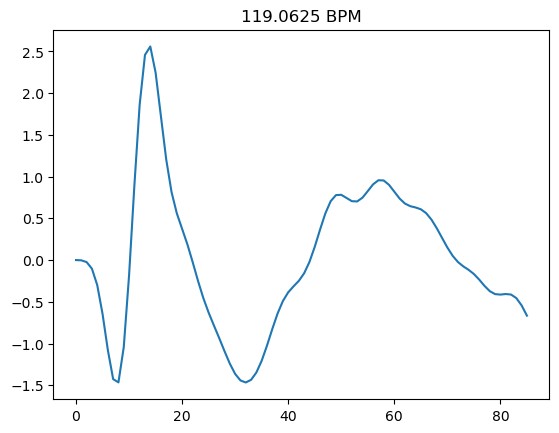

In [ ]:
plt.plot(ppg_signal)
plt.title(f"{heart_rate} BPM")

Text(0.5, 0.98, '119.0625 BPM')

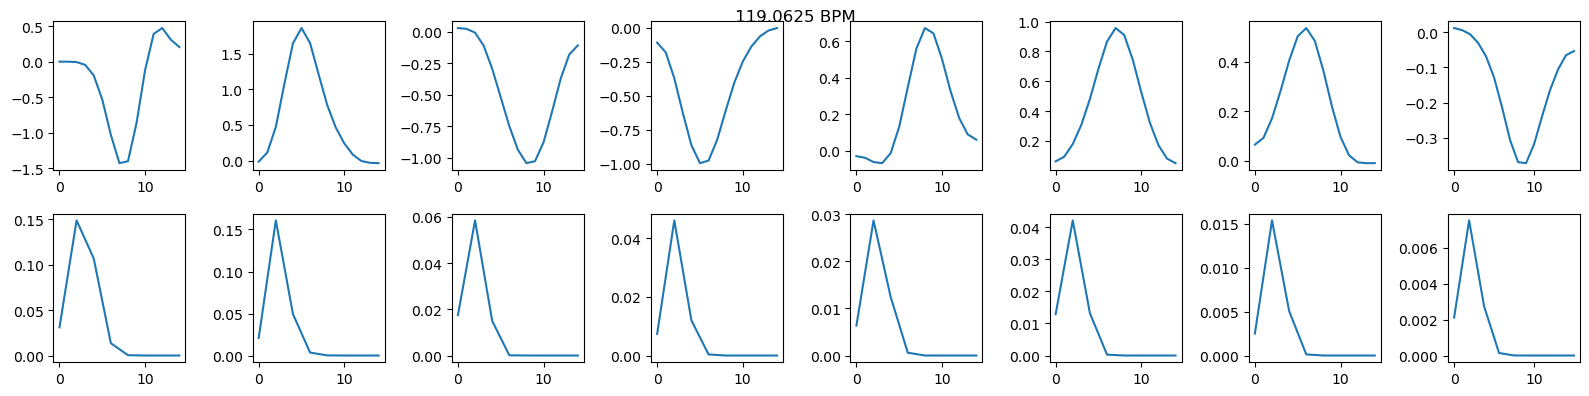

In [ ]:
fig, ax = plt.subplots(2,8, figsize=(16,4))

for s,segment in enumerate(segments):
    ax[0,s].plot(segment)

for s,psd in enumerate(segments_psd):
    ax[1,s].plot(psd[0],psd[1])

fig.tight_layout()
fig.suptitle(f"{heart_rate} BPM")

In [ ]:
# fh = 0
# for psd in segments_psd:
#     print(psd[0][np.argmax(psd[1])],psd[0][np.argmax(psd[1])]*60)
#     fh += psd[0][np.argmax(psd[1])]*60
# print(f"{fh/len(segments_psd)} BPM")

In [ ]:
for frame in skin_frames:
    cv2.imshow("Example",frame)
    if cv2.waitKey(1) & 0xFF == ord("q"):
            break
cv2.destroyAllWindows()